<a href="https://colab.research.google.com/github/ordavidov/ocl_lab/blob/aaai/poi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install doframework

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
import numpy as np
from scipy.stats import norm, multivariate_normal

In [ ]:
from doframework.core.gp import gp_model
from doframework.core.poi import probability_of_improvement, POI
from doframework.core.utils import sample_standard_simplex

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/ocl_lab/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ocl_lab/data


# Probability of Improvement (PoI) and Constraint Satisfaction (PoCS)

___

$\newcommand{\R}{\mathbb{R}}
\newcommand{\bg}{\mathbf{g}}
\newcommand{\bh}{\mathbf{h}}
\newcommand{\bhh}{{\widehat \bh}}
\newcommand{\bx}{\mathbf{x}}
\newcommand{\bxh}{{\widehat \bx}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\bzero}{\mathbf{0}}$

A mathematical decision-optimization (DO) model with decision variables $\bx \in \R^n$ and uncontrollable variables $\by \in \R^k$ may include parts $f$ (objective) and $h$ (constraint) that need to be learned from data.

$$\begin{array}{rll}
\bx^*(\by) \in \arg \min_{\bx \in \R^n, \bz \in \R^m} & f(\bx,\by,\bz) & \\
\mbox{s.t.} & \bg(\bx,\by,\bz) \leq \bzero \\
& \bz = {\bh} (\bx,\by) & \\
& \bx \in \Omega(\by) & \mbox{(polytope)}
\end{array}$$
        
This notebook demonstrates the use of the Probability of Improvement (**PoI**) and the Probability of Constraint satisfaction (**PoCS**) as a means to test the quality of a solution $\bxh = \bxh(\by)$ coming from a *learned* mathematical decision-optimization model associated with an uncotrollable parameter value $\by$.

# Test Function

We will demonstrate PoI and PoCS using the test function below. It will serve us both as a possible (true) constraint $h$ in some mathematical DO model and later as a possible (true) objective $f$.

In [ ]:
f = lambda x, w: (x**2 + w**2)*np.sin(np.pi*x*w/16)
fvect = np.vectorize(f)

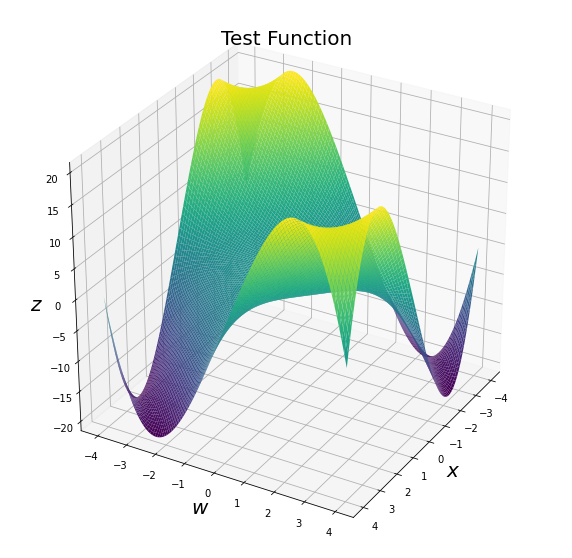

In [ ]:
fig = plt.figure(figsize=(10,10))
ln = np.linspace(-4,4,100)[:,None]
x, y = np.meshgrid(ln, ln)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, fvect(x,y), rstride=1, cstride=1, cmap=cm.viridis)
ax.view_init(elev=30, azim=30)
ax.set_xlabel(r'$x$',fontsize=20)
ax.set_ylabel(r'$w$',fontsize=20)
ax.set_zlabel(r'$z$',fontsize=20)
ax.set_title(r'Test Function',fontsize=20);

# Data

We will generate synthetic noised data for the test function. This data poses as historical data associated with the test function in its incarnation either as an objective $f$ or as a constraint $h$.

We will generate data from a multivariate, non-spherical normal distribution (just to keep things a bit interesting).

In [ ]:
d = 2 # dimension
N = 500 # number of points in dataset
noise = 0.5 # noising function values

In [ ]:
mu = np.zeros(d)
sigma = np.diag(2*d*sample_standard_simplex(d))
X = multivariate_normal(mean=mu,cov=sigma).rvs(size=N)

In [ ]:
y = fvect(X[:,0],X[:,1]) + norm(loc=0,scale=noise).rvs(size=X.shape[0])
y = y[:,None]

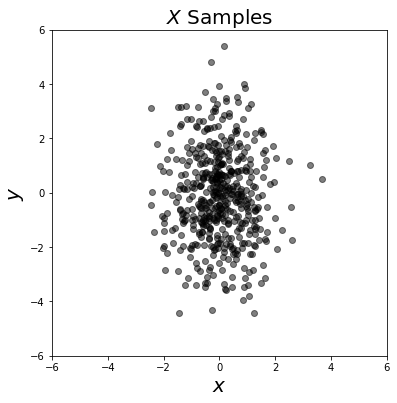

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.scatter(X[:,0],X[:,1],color='black',alpha=0.5)
ax.set_xlabel(r'$x$',fontsize=20)
ax.set_ylabel(r'$y$',fontsize=20)
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_title(r'$X$ Samples',fontsize=20);

# GP 

To calculate PoI and PoCS we use a __[Gaussian Process (GP)](http://gaussianprocess.org/gpml/)__ model. 

The basic GP model below relies on Maximum Likelihood Estimatiom (MLE) to optimize the hyper-parameters of the Gaussian process ARD (Automatic Relevance Determination) kernel. 

In [ ]:
model = gp_model(X,y)

Let's test the model's prediction $\mu$ at the origin $\bz$ and its variance $\sigma$. This is where we expect low variance.

In [ ]:
origin = np.array([[0.,0.]])
mu_origin, sigma_origin = model.predict(origin)
mu_origin, sigma_origin = mu_origin[0][0], sigma_origin[0][0]
print('f value at the origin: {:.3f}'.format(f(origin[0,0],origin[0,1])))
print('mu at the origin: {:.3f}'.format(mu_origin))
print('sigma at the origin: {:.3f}'.format(sigma_origin))

f value at the origin: 0.000
mu at the origin: 0.006
sigma at the origin: 0.272


We can also use __[Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo)__ (HMC) to optimize GP kernel hyper-parameters. We use the following parameters to enable this option.

* ```is_mcmc```: True to use HMC to optimize kernel hyper-parameters.
* ```num_samples```: number of samples in an MC chain.
* ```hmc_iters```: number of MC chains to sample.
* ```plot_kernel_posteriors```: True to plot kernel hyper-parameter posteriors when using HMC.

The kernel noise reflects the noise we introduced to function values. The kernel length scales reflect how far we need to move in each coordinate for function values to become uncorrelated. Here, we expect the two length scales to be close, since the function is symmetric in $x$ and $y$. However, the length scales will also be effected by the density of data in each coordinate direction. The more spherical $\Sigma$ is, the closer they will be. Length scales around $l=8$ make sense for a near rounded multivariate Gaussian, since the sine function is added $\pi/2$.

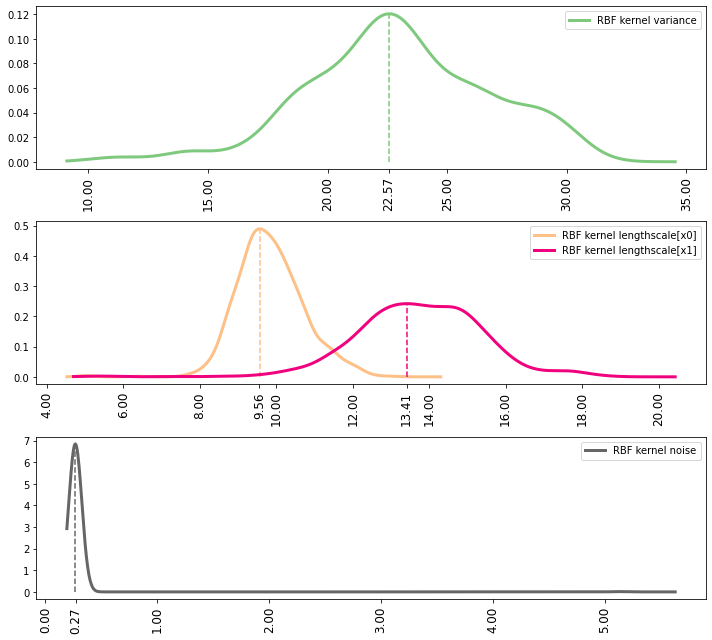

In [ ]:
model_hmc = gp_model(X,y,is_mcmc=True,num_samples=1000,hmc_iters=5,plot_kernel_posteriors=True)

# PoCS

The Probability of Constraint Satisfaciton (PoCS) at a point $(\bx',\by')$ is defined as

$$\Pr[\bh(\bx',\by') \leq t],$$

namely, the probability that the value of the constraint $\bh$ at $(\bx',\by')$ is $\leq$ than some threshold $t$. Assuming that the vector-valued function $\bg$ incorporates the constraint 

$$\bz - t \leq \bzero,$$

PoCS assists us in establishing the probability that some solution $\bxh = \bxh(\by)$ coming from a *learned* mathematical DO model associated with an uncontrolable parameter $\by$ is indeed *truely* feasible.

In this example, the test function will act as the true constraint $h$ of which we have historical data. We wish to estimate $\Pr[h(\bx',\by') \leq t]$.

Let's choose some demi solutions, uncontrollable values, and thresholds to test the PoCS.

**points**: proposed optimal "solutions" $\bxh$ associated with uncontrollable parameter values $\by$.<br>
**ts**: proposed thresholds $t$.

The 1st coordinate of each point represents a proposed "solution", while the 2nd coordinate represents the uncontrollable value associated with this "solution".

In [ ]:
points = np.array([[1.,1.],[1.,-1.],[3.,3.],[4.,4.]])
ts = np.array([[2.,2.,2.,2.]])

Here is how we calculate the PoCS using the function ```probability_of_improvement```.

In [ ]:
probability_of_improvement(points,ts,model,is_constraint=True,upper_bound=True)

[POI(point=[1. 1.], probability=0.99887, upper_bound=True, threshold=[2.]),
 POI(point=[1. 1.], probability=0.99876, upper_bound=True, threshold=[2.]),
 POI(point=[1. 1.], probability=0.99876, upper_bound=True, threshold=[2.]),
 POI(point=[1. 1.], probability=0.99886, upper_bound=True, threshold=[2.]),
 POI(point=[ 1. -1.], probability=0.99999, upper_bound=True, threshold=[2.]),
 POI(point=[ 1. -1.], probability=1.0, upper_bound=True, threshold=[2.]),
 POI(point=[ 1. -1.], probability=0.99999, upper_bound=True, threshold=[2.]),
 POI(point=[ 1. -1.], probability=1.0, upper_bound=True, threshold=[2.]),
 POI(point=[3. 3.], probability=0.0, upper_bound=True, threshold=[2.]),
 POI(point=[3. 3.], probability=0.0, upper_bound=True, threshold=[2.]),
 POI(point=[3. 3.], probability=0.0, upper_bound=True, threshold=[2.]),
 POI(point=[3. 3.], probability=0.0, upper_bound=True, threshold=[2.]),
 POI(point=[4. 4.], probability=0.0, upper_bound=True, threshold=[2.]),
 POI(point=[4. 4.], probability=

Let's see if the HMC model gives us different results.

In [ ]:
probability_of_improvement(points,ts,model_hmc,is_constraint=True,upper_bound=True)

[POI(point=[1. 1.], probability=1.0, upper_bound=True, threshold=[2.]),
 POI(point=[1. 1.], probability=1.0, upper_bound=True, threshold=[2.]),
 POI(point=[1. 1.], probability=1.0, upper_bound=True, threshold=[2.]),
 POI(point=[1. 1.], probability=1.0, upper_bound=True, threshold=[2.]),
 POI(point=[ 1. -1.], probability=1.0, upper_bound=True, threshold=[2.]),
 POI(point=[ 1. -1.], probability=1.0, upper_bound=True, threshold=[2.]),
 POI(point=[ 1. -1.], probability=1.0, upper_bound=True, threshold=[2.]),
 POI(point=[ 1. -1.], probability=1.0, upper_bound=True, threshold=[2.]),
 POI(point=[3. 3.], probability=0.01412, upper_bound=True, threshold=[2.]),
 POI(point=[3. 3.], probability=0.01427, upper_bound=True, threshold=[2.]),
 POI(point=[3. 3.], probability=0.0137, upper_bound=True, threshold=[2.]),
 POI(point=[3. 3.], probability=0.01409, upper_bound=True, threshold=[2.]),
 POI(point=[4. 4.], probability=0.99738, upper_bound=True, threshold=[2.]),
 POI(point=[4. 4.], probability=0.997

The further away we get from the data, the less likely it is we'll get high probability values. As we get away from the data, we should consider lower probability values to reflect not only lower predictions but, crucially, lower knowledge or lower certainty.

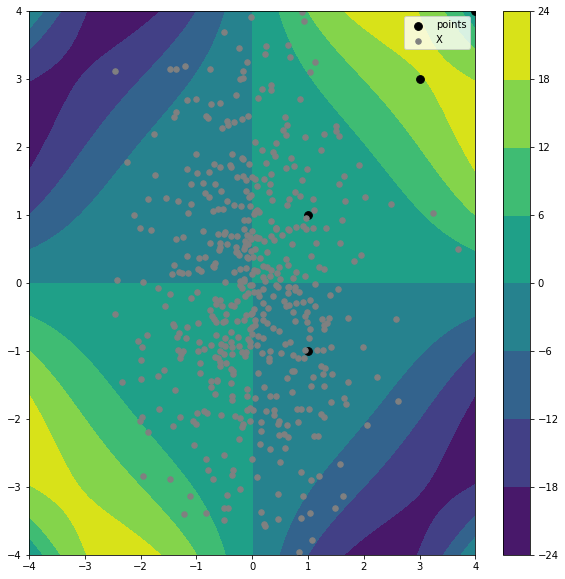

In [ ]:
fig = plt.figure(figsize=(10,10))
ln = np.linspace(-4,4,1000)[:,None]
x, y = np.meshgrid(ln, ln)

plt.contourf(x, y, fvect(x,y), cmap=cm.viridis)
plt.colorbar()
plt.scatter(points[:,0],points[:,1],c='black',s=60,label='points')
plt.scatter(X[:,0],X[:,1],c='grey',s=30,label='X')
plt.xlim(-4,4)
plt.ylim(-4,4)

plt.legend()
plt.show()

# POI 

The Probability of Improvement (PoI) at a point $(\bx',\by)$ is defined relative to another point $(\bx'',\by)$ to be

$$\Pr[f(\bx',\by) \leq f(\bx',\by)].$$

As the name suggests, it is the probability that the value of the objective $f$ at $\bx'$ improves upon some other $\bx''$ for the uncontrolable parameter $\by$. 

PoI assists us in establishing the probability that some solution $\bxh = \bxh(\by)$ coming from a *learned* mathematical DO model associated with an uncontrolable parameter $\by$ is likely to be better than some known decision $\bx_0 = \bx_0(\by)$.

In this example, the test function will act as the true objective $f$ of which we have historical data. We'll choose some demi solutions ${\widehat x}$ to test against prior decisions $x_0$ associated with uncontrollable values $y$ and then test the PoI.

**points**: proposed "solutions" ${\widehat x}$ associated with uncontrollable parameter values $y$.<br>
**references**: prior decisions $x_0$ that serve as references.

The 1st coordinate of each point represents a proposed "solution", while the 2nd coordinate represents the uncontrollable value associated with this "solution".

In [ ]:
points = np.array([[1.,2.],[3.,2.]])
references = np.array([[2.,2.]])

The probability of improvement agrees with our expectations.

In [ ]:
probability_of_improvement(points,references,model,plot_joint_gaussians=False)

[POI(point=[1. 2.], probability=1.0, upper_bound=True, reference=[2. 2.]),
 POI(point=[3. 2.], probability=0.0, upper_bound=True, reference=[2. 2.])]